In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations, chain, product

%load_ext line_profiler

%matplotlib inline

In [2]:
import mipcl_py.mipshell.mipshell as mip

# We create a class MILP which maximizes f.u under the constraints Au <= b for u an array of integers between lb and ub
class hMWT(mip.Problem):
    def model(self,x,NUmax):
        nb_edges = len(x.matchingGraph.edges)
        nb_nodes = x.matchingGraph.n
        
        self.u = u = mip.VarVector([nb_edges],"u",mip.INT,lb=0,ub=NUmax)
        grad_h = ...

        mip.maximize(mip.sum_(u[i]*grad_h[i] for i in range(nb_edges)))

        # The inequalities constraints:
        # The number of matchings can not be higher than NUmax
        mip.sum_(u[i] for i in range(nb_edges)) <= NUmax
        # The number of matchings can not be higher than the number of items in the system
        for j in range(nb_nodes):
            mip.sum_(u[1]) <= x.items[1]
            mip.sum_(u[2]+u[3]) <= x.items[2]

   

In [38]:
W = MatchingGraph([["d1", "s1"],["d2", "s1"],["d2", "s2"],["d3", "s2"]],3,2)
d = pd.Series({"d1":1,"d2":2,"d3":1,"s1":2,"s2":2})
N = State(d,W)
Nbis = N.copy()
S = NodesData.zeros(W)
#N[["d3","s2"]] += 1

In [39]:
W.demand_class_subsets

[('d1',),
 ('d2',),
 ('d3',),
 ('d1', 'd2'),
 ('d1', 'd3'),
 ('d2', 'd3'),
 ('d1', 'd2', 'd3')]

In [40]:
W.demandToSupply

{('d1',): ['s1'],
 ('d1', 'd2'): ['s1', 's2'],
 ('d1', 'd2', 'd3'): ['s1', 's2'],
 ('d1', 'd3'): ['s1', 's2'],
 ('d2',): ['s1', 's2'],
 ('d2', 'd3'): ['s1', 's2'],
 ('d3',): ['s2']}

In [45]:
M = Matching(N,pd.Series({"d1":1,"d2":1,"d3":0,"s1":2,"s2":0}))
M.data

d1    1
d2    1
d3    0
s1    2
s2    0
dtype: int64

In [51]:
N -= M
N.data

d1   -4
d2   -3
d3    1
s1   -8
s2    2
dtype: int64

In [127]:
N.matchings_available_subgraph().maximal_matchings()

[[['d1', 's1']]]

In [124]:
N.matchings_available()

[['d1', 's1'], ['d3', 's2']]

In [13]:
N.demand

d1    1
d2    0
d3    1
dtype: int64

In [19]:
for key in d.keys():
    if key in ['d1','d2','d3','s1','s2']:
        print(key)
    else:
        print('error')

d1
d2
s1
d3
s2
error


In [67]:
np.where(d>=2)[0]

array([4])

In [68]:
l = np.array(['g',4,8,9,-87])
l[np.where(d>=2)[0]] #+ np.array([1, 1-self.nb_demand_classes])

array(['-87'],
      dtype='<U3')

In [41]:
S = pd.Series([1,2,8,-4],index=['a','b','c','d'])
l=('a','c')
S[list(l)]+=1
S


a    2
b    2
c    9
d   -4
dtype: int64

In [137]:
class A:
    
    def __init__(self,a,b):
        self.a = a
        self.b = b
        
    def test_in(self,x):
        return self.a in x
        
    def __getitem__(self,index):
        print('get')
        if index=='a':
            return self.a
        elif index=='b':
            return self.b
        else:
            return 0
        
    def __setitem__(self,index,value):
        print('set')
        if index=='a':
            self.a = value
        elif index=='b':
            self.b = value
        else:
            pass

In [138]:
t = A(3,4)
t['a'] += 7

get
set


In [139]:
t['a']

get


10

In [20]:
map(list,combinations(['d1','d2','d3'], 1))

In [22]:
[list(c) for c in chain.from_iterable(combinations(['d1','d2','d3'], r) for r in np.arange(1,3))]

[['d1'], ['d2'], ['d3'], ['d1', 'd2'], ['d1', 'd3'], ['d2', 'd3']]

In [46]:
class MatchingGraph:
    
    def __init__(self, edges, nb_demand_classes, nb_supply_classes):
        # Edges must be a list of arrays ['di','sj'] if demand class i can be matched with supply class j
        self.edges = edges
        
        self.nb_supply_classes = nb_supply_classes
        # We compute the set and all subsets of demand classes
        self.nb_demand_classes = nb_demand_classes
        self.demand_class_set = ['d'+str(i) for i in np.arange(1,self.nb_demand_classes+1)]
        self.demand_class_subsets = [list(c) for c in chain.from_iterable(combinations(self.demand_class_set, r) for r in np.arange(1,self.nb_demand_classes+1))]
        # We create a dictionary which maps each subset of demand classes to the subset of supply classes to witch its linked
        self.build_demandToSupply()
        # We compute the set and all subsets of supply classes
        self.supply_class_set = ['s'+str(j) for j in np.arange(1,nb_supply_classes+1)]
        self.supply_class_subsets = [list(c) for c in chain.from_iterable(combinations(self.supply_class_set, r) for r in np.arange(1,nb_supply_classes+1))]
        # We create a dictionary which maps each subset of supply classes to the subset of demand classes to witch its linked
        self.build_supplyToDemand()
        
    @property
    def n(self):
        return self.nb_demand_classes + self.nb_supply_classes
    
    @property
    def nodes(self):
        # We create a list of all nodes with first the demand classes and then the supply classes, both in increasing order
        return np.array(self.demand_class_set + self.supply_class_set)
        
    def build_demandToSupply(self):
        # We create a dictionary which maps each subset of demand classes to the subset of supply classes to witch its linked
        self.demandToSupply = {}
        for subset in self.demand_class_subsets:
            supply_subset = set()
            for edge in self.edges:
                if edge[0] in subset:
                    supply_subset.add(edge[1])
            self.demandToSupply[tuple(subset)] = list(supply_subset)
            
    def build_supplyToDemand(self):
        # We create a dictionary which maps each subset of supply classes to the subset of demand classes to witch its linked
        self.supplyToDemand = {}
        for subset in self.supply_class_subsets:
            demand_subset = set()
            for edge in self.edges:
                if edge[1] in subset:
                    demand_subset.add(edge[0])
            self.supplyToDemand[tuple(subset)] = list(demand_subset)
            
    def isEdge(self,e):
        return e in self.edges
        
    def degree(self):
        # We count the degree of each node
        d = pd.Series(np.zeros(self.n),index=self.nodes)
        for edge in self.edges:
            d[edge] += 1
        return d
    
    def maximal_matchings(self):
        # We compute all the maximal matchings of the matching graph. This function only makes sense if it called on the MatchingGraph returned by available_matchings_subgraph()
        list_maximal_matchings = []
        deg = self.degree()
        # We look at all nodes of degree superior than 2 (there can not be more than 2)
        if (deg<2).all():
            # If the degree of each node is less than two then all the edges of the matching graph form the only maximal matching
            list_maximal_matchings.append(self.edges)
        elif np.sum(deg>=2)==1:
            # We get the name of the node
            node = self.nodes[np.where(deg>=2)[0]]
            # We test if it is a demand class or a supply class
            if node.startswith('d'):
                # We get all the supply classes that can be matched with arrival demand class
                S_i = self.demandToSupply[(node,)]
                # We test if there is still an edge we can matched after having matched the arrival demand class
                remaining_edge = [list(el) for el in set(tuple(edge) for edge in self.edges).difference(tuple(node, supply_class) for supply_class in S_i)]
                if remaining_edge:
                    for supply_class in S_i:
                        list_maximal_matchings.append([[node,supply_class],remaining_edge])
                else:
                    for supply_class in S_i:
                        list_maximal_matchings.append([[node,supply_class]])
            else:
                # We get all the demand classes that can be matched with arrival supply class
                D_j = self.supplyToDemand[(node,)]
                # We test if there is still an edge we can matched after having matched the arrival supply class
                remaining_edge = [list(el) for el in set(tuple(edge) for edge in self.edges).difference(tuple(demand_class, node) for demand_class in D_j)]
                if remaining_edge:
                    for demand_class in D_j:
                        list_maximal_matchings.append([[demand_class, node],remaining_edge])
                else:
                    for demand_class in D_j:
                        list_maximal_matchings.append([[demand_class, node]])
        else:       
            # We get the demand class and the supply class of the arrivals by selecting the only two nodes that have a degree greater than 2
            arrivals_classes = self.nodes[np.where(deg>=2)[0]]
            # We get all the supply classes that can be matched with arrival demand class
            S_i = self.demandToSupply[(arrivals_classes[0],)]
            # We get all the demand classes that can be matched with arrival supply class
            D_j = self.supplyToDemand[(arrivals_classes[1],)]
            
            if arrivals_classes[1] in S_i:
                # If both arrivals can be matched together, we add their matching as a maximal matching and remove them from S_i and D_j
                list_maximal_matchings.append([arrivals_classes])
                S_i.remove(arrivals_classes[1])
                D_j.remove(arrivals_classes[0])
                
            # We get all remaining maximal matchings by combining any possible matching of arrival demand class with any possible matching of arrival supply class
            for classes in product(S_i,D_j):
                list_maximal_matchings.append([[arrivals_classes[0],classes[0]],[classes[1],arrivals_classes[1]]])
            
        return list_maximal_matchings
    
# We define a class NodesData which is a data structure for our system. 
# It stores a value for each classes of demand and supply items.
# It is used for example to store the length of the queues, the holding costs or the arrival rates
class NodesData:
        
    def __init__(self, S, matchingGraph):
        # The values must be stored, in an Pandas Series S, with an index as such: first the demand items, then the supply items and both sorted by classes in increasing order
        # This means that index i represent demand class i+1 and index nb_demand_classes+j represent supply class j+1
        self.data = S
        self.matchingGraph = matchingGraph
      
    @classmethod
    def fromDict(cls, D, matchingGraph):
        # The values must be stored in a dictionnary D where the keys are the nodes 
        for node in D.keys():
            if node not in matchingGraph.nodes:
                raise ValueError('A key from the dictionnary does not corespond to a node of the matching graph')
        cls(pd.Series(D),matchingGraph)
        
    @classmethod
    def fromArray(cls, A, matchingGraph):
        # The values must be stored, in an array A, as such: first the demand items, then the supply items and both sorted by classes in increasing order
        # This means that index i represent demand class i+1 and index nb_demand_classes+j represent supply class j+1
        return cls(pd.Series(A,index=matchingGraph.nodes),matchingGraph)
        
    @classmethod
    def zeros(cls, matchingGraph):
        # We create an empty state
        return cls.fromArray(np.zeros(matchingGraph.n), matchingGraph)
    
    @classmethod
    def items(cls, demand_items, supply_items, matchingGraph):
        # We create a state by giving two separate array for demand and supply items
        return cls.fromArray(np.hstack((demand_items,supply_items)), matchingGraph)
    
    @property
    def values(self):
        return self.data.values
    
    @property
    def demand(self):
        return self.data[self.matchingGraph.demand_class_set]
    
    @property
    def supply(self):
        return self.data[self.matchingGraph.supply_class_set]
    
    def __getitem__(self, index):
        return self.data[index]
    
    def __setitem__(self, index, value):
        self.data[index] = value
    
    def __add__(self, other):
        return self.__class__(self.data + other.data, self.matchingGraph)
    
    def __iadd__(self, other):
        self.data += other.data
        return self   
    
    def copy(self):
        return self.__class__(self.data.copy(),self.matchingGraph)

# We define a class State which is a NodesData with the constraint that demand and supply items must be positives and their sum equal
# It is used for example to store the length of the queues, arrival items or matchings
class State(NodesData):
    
    def __init__(self, values, matchingGraph):
        # We test that the number of demand items and the number of supply items are positives
        if (values < 0).any():
            raise ValueError("The number of demand items and the number of supply items must be positives.")
        # We test that the sum of demand items is equal to the sum of supply items
        if values[matchingGraph.demand_class_set].sum() != values[matchingGraph.supply_class_set].sum():
            raise ValueError("The sum of demand items must be equal to the sum of supply items.")
        # We use the NodesData initialization
        super(State,self).__init__(values, matchingGraph)      
        
    def matchings_available(self):
        # We construct a list of all the edges which can be matched given the State
        list_edges = []
        for edge in self.matchingGraph.edges:
            if (self.data[edge]>=1).all():
                list_edges.append(edge)
        return list_edges
    
    def matchings_available_subgraph(self):
        # We construct a subgraph composed of all the edges which can be matched given the State
        return MatchingGraph(self.matchings_available(), self.matchingGraph.nb_demand_classes, self.matchingGraph.nb_supply_classes)
    
    def __iadd__(self, other):
        if isinstance(other, State):
            self.data += other.data
            return self
        else:
            raise TypeError("A State can only be added with another State")
    
    def __sub__(self, other):
        if isinstance(other, Matching):
            return State(self.data - other.data, self.matchingGraph) 
        else:
            raise TypeError("Items from a State can only be substracted with a Matching")
        
    def __isub__(self, other):
        if isinstance(other, Matching):
            self.data -= other.data
            return self 
        else:
            raise TypeError("Items from a State can only be substracted with a Matching")
    
# We define a class Virtual State that acts as a State excepts that we allow negative values. 
# This type of states are used in Stolyar policy
class Virtual_State(NodesData):
    
    def __init__(self, values, matchingGraph):
        # We test that the sum of demand items is equal to the sum of supply items
        if values[matchingGraph.demand_class_set].sum() != values[matchingGraph.supply_class_set].sum():
            raise ValueError("The sum of demand items must be equal to the sum of supply items.")
        # We use the NodesData initialization
        super(Virtual_State,self).__init__(values, matchingGraph) 
        
    def __iadd__(self, other):
        if isinstance(other, State) or isinstance(other, Virtual_State):
            self.data += other.data
            return self
        else:
            raise TypeError("A Virtual_State can only be added with another Virtual_State or another State")
    
    def __sub__(self, other):
        if isinstance(other, Virtual_Matching):
            return Virtual_State(self.data - other.data, self.matchingGraph) 
        else:
            raise TypeError("Items from a State can only be substracted with a Virtual Matching")
        
    def __isub__(self, other):
        if isinstance(other, Virtual_Matching):
            self.data -= other.data
            return self 
        else:
            raise TypeError("Items from a State can only be substracted with a Virtual Matching")
            
    
# We create a Matching class which is a State with more restrictions.
# A matching can only add pairs of demand and supply items if they are associated to an edge in the matching graph.
# A matching has a reference to a State and can't have more items than the referenced State in any nodes.
class Matching(State):
    
    def __init__(self, x, values):
        super(Matching,self).__init__(values, x.matchingGraph)
        # We store a reference to the State on which we will perform matchings
        self.x = x
        # We test if the number of matchings is higher than the number of items in the State
        if (values > x.data).any():
            raise ValueError("The number of matched items can't be superior than the number of items in the State at any nodes")
        if not self.feasible():
            raise ValueError("This matching is not feasible")
    
    def feasible(self):
        feasible_matching = True
        for subset in self.matchingGraph.demand_class_subsets:
            if self.data[subset].sum() > self.data[self.matchingGraph.demandToSupply[tuple(subset)]].sum():
                feasible_matching = False
        for subset in self.matchingGraph.supply_class_subsets:
            if self.data[subset].sum() > self.data[self.matchingGraph.supplyToDemand[tuple(subset)]].sum():
                feasible_matching = False
        return feasible_matching
    
    @classmethod
    def fromDict(cls, x, D):
        # The values must be stored in a dictionnary D where the keys are the nodes 
        for node in D.keys():
            if node not in x.matchingGraph.nodes:
                raise ValueError('A key from the dictionnary does not corespond to a node of the matching graph')
        cls(x, pd.Series(D))
        
    @classmethod
    def fromArray(cls, x, A):
        # The values must be stored, in an array A, as such: first the demand items, then the supply items and both sorted by classes in increasing order
        # This means that index i represent demand class i+1 and index nb_demand_classes+j represent supply class j+1
        return cls(x, pd.Series(A,index=x.matchingGraph.nodes))
        
    @classmethod
    def zeros(cls, x):
        # We create an empty state
        return cls.fromArray(x, np.zeros(x.matchingGraph.n))
    
    @classmethod
    def items(cls, x, demand_items, supply_items):
        # We create a state by giving two separate array for demand and supply items
        return cls.fromArray(x, np.hstack((demand_items,supply_items)))
    
    def __setitem__(self, index, value):
        # We test if the demand class i can be matched with the supply class j
        if self.matchingGraph.isEdge(index):
            # We test if the number of matchings has exceed the number of items in the State
            if (value>self.x[index]).any():
                raise ValueError("The number of matched items can't be superior than the number of items in the State at any nodes")
            else:
                self.data[index] = value
        else:
            raise ValueError("The pair do not correspond to an edge in the matching graph")
            
    def copy(self):
        return Matching(self.x,self.data.copy())
            
# We define a Virtual Matching class which is the same as the Matching class excepts that we allow matchings to be made even if there is not enough items.
# This type of matching is used in Stolyar policy
class Virtual_Matching(State):
    
    def __init__(self, x, values):
        super(Virtual_Matching,self).__init__(values, x.matchingGraph)
        # We store a reference to the State on which we will perform matchings
        self.x = x
        # We test if the matching is feasible, i.e if it is a linear combination of edges from the matching graph
        if not self.feasible():
            raise ValueError("This matching is not feasible")
    
    def feasible(self):
        feasible_matching = True
        for subset in self.matchingGraph.demand_class_subsets:
            if self.data[slice(*subset)].sum() > self.data[self.matchingGraph.demandToSupply[subset]].sum():
                feasible_matching = False
        for subset in self.matchingGraph.supply_class_subsets:
            if self.data[slice(*subset)].sum() > self.data[self.matchingGraph.supplyToDemand[subset]].sum():
                feasible_matching = False
        return feasible_matching
    
    @classmethod
    def fromDict(cls, x, D):
        # The values must be stored in a dictionnary D where the keys are the nodes 
        for node in D.keys():
            if node not in x.matchingGraph.nodes:
                raise ValueError('A key from the dictionnary does not corespond to a node of the matching graph')
        cls(x, pd.Series(D))
        
    @classmethod
    def fromArray(cls, x, A):
        # The values must be stored, in an array A, as such: first the demand items, then the supply items and both sorted by classes in increasing order
        # This means that index i represent demand class i+1 and index nb_demand_classes+j represent supply class j+1
        return cls(x, pd.Series(A,index=x.matchingGraph.nodes))
        
    @classmethod
    def zeros(cls, x):
        # We create an empty state
        return cls.fromArray(x, np.zeros(x.matchingGraph.n))
    
    @classmethod
    def items(cls, x, demand_items, supply_items):
        # We create a state by giving two separate array for demand and supply items
        return cls.fromArray(x, np.hstack((demand_items,supply_items)))
    
    def __setitem__(self, index, value):
        # We test if the demand class i can be matched with the supply class j
        if self.matchingGraph.isEdge(index):
            self.data[index] = value
        else:
            raise ValueError("The pair do not correspond to an edge in the matching graph")
            
    def copy(self):
        return Virtual_Matching(self.x,self.data.copy())
        
          
class Model:
    
    def __init__(self, matchingGraph, arrival_dist, costs, x_0):
        self.matchingGraph = matchingGraph
        # We initialize the class probabilities
        self.arrival_dist = arrival_dist
        # We stores the holding costs
        self.costs = costs
        # We initialize the state of the system (the length of each queue)
        self.x_0 = x_0
        
    def sample_arrivals(self):
        a = State.zeros(self.matchingGraph)
        # We sample the class of the demand item
        d = np.random.choice(self.matchingGraph.demand_class_set,p=self.arrival_dist.demand)
        # We sample the class of the supply item
        s = np.random.choice(self.matchingGraph.supply_class_set,p=self.arrival_dist.supply)
        a[[d,s]]+=1
        return a
    
    def iterate(self,states_list,policies):
        # We sample new arrivals
        arrivals = self.sample_arrivals()
        for p, policy in enumerate(policies):
            # We apply the matchings
            states_list[p] -= policy.match(states_list[p]) 
            # We add the arrivals
            states_list[p] += arrivals
        #return states_list
        
    def run(self, nb_iter, policies, traj=False, plot=False):
        nb_policies = len(policies)
        # states_list stores the state of the system under each policy given by the list policies
        states_list = []
        # We intialize each state to the initial state of the model x_0 and reset each policy
        for policy in policies:
            states_list.append(self.x_0.copy())
            policy.reset_policy(self.x_0)
            
        if plot:
            traj = True
        if traj:
            # We keep the trajectory of the system under each policy
            state_size = self.matchingGraph.n
            trajectories = np.zeros((nb_policies,state_size,nb_iter+1))
            trajectories[:,:,0] = self.x_0.values
            for i in np.arange(nb_iter):
                self.iterate(states_list,policies) 
                trajectories[:,:,i+1] = [state.values for state in states_list]
            
            if plot:
                # We plot the trajectories
                fig, axes = plt.subplots(nb_policies,1,figsize=(15,nb_policies*5),squeeze=0)
                for p, policy in enumerate(policies):
                    for e in np.arange(state_size):
                        lab = "d_"+str(e+1) if e<self.matchingGraph.nb_demand_classes else "s_"+str(e-self.matchingGraph.nb_demand_classes+1)
                        axes[p,0].plot(trajectories[p,e,:],label=lab)
                    axes[p,0].legend(loc='best')
                    axes[p,0].set_title(str(policy))
            return trajectories
        else:
            for _ in np.arange(nb_iter):
                self.iterate(states_list,policies)
            return states_list
        
    def average_cost(self, nb_iter, policies, plot=False):
        x_traj = self.run(nb_iter, policies, traj=True)
        costs_traj = [np.cumsum(np.dot(self.costs.values.reshape(1,-1),x_traj[i,:,:]))/np.arange(1.,nb_iter+2) for i in np.arange(len(policies))]
        if plot:
            # We plot the costs trajectory
            plt.figure(figsize=(15,5))
            for p, policy in enumerate(policies):
                plt.plot(costs_traj[p],label=str(policy))
            plt.legend(loc='best')
        return costs_traj
        
        

In [47]:
# We define a class for policies
class Policy:

    def match(self,x):
        raise NotImplementedError
        
    def reset_policy(self, x_0):
        pass
    
    def __str__(self):
        pass
    
# We define various policies by creating child class from Policy and implementing the function match()

# We define a random policy which choose a random possible (depending on the State) matching. 
# The policy has a parameter that gives the maximum number of times we repeat the last operation.
class Random_policy(Policy):
    
    def __init__(self,nb_matchings_max=np.inf):
        assert nb_matchings_max==np.inf or (type(nb_matchings_max)==int and nb_matchings_max>=1)
        self.nb_matchings_max = nb_matchings_max
    
    def match(self,x):
        nb_matchings = 0
        u = Matching.zeros(x)
        possible_matchings = x.matchings_available()
        while nb_matchings < self.nb_matchings_max and possible_matchings:
            edge = possible_matchings[np.random.randint(len(possible_matchings))]
            u[edge] += 1
            nb_matchings += 1
            new_state = x - u
            possible_matchings = new_state.matchings_available()
        return u
    
    def __str__(self):
        return 'Random policy m={}'.format(self.nb_matchings_max)
    
class Threshold_policy(Policy):
    
    def __init__(self,thresholds):
        # We store the thresholds as [s_1, s_2]
        self.thresholds = thresholds
        
    def match(self,x):
        u = Matching.zeros(x)
        # We match all l4
        u[['d3','s2']] += x[['d3','s2']].min()
        # We match all l1
        u[['d1','s1']] += x[['d1','s1']].min()
        # We update the state with the matchings in l4 and l1 because they have priority and they influence the ones in l2 and l3
        new_state = x - u
        # We match all l2 above the s_1 threshold
        l2_matchings = np.maximum(new_state[['d2','s1']].min() - self.thresholds[0], 0)
        u[['d2','s1']] += l2_matchings
        # We match all l3 above the s_2 threshold
        l3_matchings = np.maximum(new_state[['d2','s2']].min() - self.thresholds[1], 0)
        u[['d2','s2']] += l3_matchings
        return u
    
    def __str__(self):
        return 'Threshold policy t={}'.format(self.thresholds)
    
class MaxWeight_policy(Policy):
    
    def __init__(self, costs):
        self.costs = costs
    
    def match(self,x):
        # We suppose that x is a stable state (i.e, before the arrivals, no more matching could have been done)
        u = Matching.zeros(x)
        # We will use a list of edges candidates that could achieve the max weight
        candidate_list = x.matchings_available_subgraph().maximal_matchings()
        candidates_costs = np.zeros(len(candidate_list))
        for i, candidate in enumerate(candidate_list):
            # For each candidate we compute the costs induced by its matchings
            for edge in candidate:
                candidates_costs[i] += np.sum(self.costs[edge])
        # We create a Matching out of the most expensive candidate
        for edge in candidate_list[np.argmax(candidates_costs)]:
            u[edge] += 1
        return u
    
    def __str__(self):
        return 'MaxWeight policy'
    
class Stolyar_policy(Policy):
    
    def __init__(self, x_0, rewards, beta, costs=None):
        self.previous_x = x_0.copy()
        self.previous_match = Matching.zeros(x_0)
        self.virtual_x = Virtual_State(x_0.values.copy(), x_0.matchingGraph)
        self.rewards = rewards
        self.beta = beta
        self.incomplete_matchings = []
        # We can include holding costs in Stolyar algorithm by giving the costs as parameter and changing the virtual system update
        if costs is not None:
            self.costs = costs
            self.update_vs = self.update_virtual_system_wCosts
        else:
            self.update_vs = self.update_virtual_system
    
    def match(self,x):
        # update the virtual system: add previous arrivals, apply algo 1 and add the matching to the incomplete queue
        self.update_vs(x)
        # We scan the queue in FCFS order until we find a feasible match given x
        # We return the feasible if one was found or we return 0.
        for match in self.incomplete_matchings:
            if (match.values <= x.values).all():
                u = Matching(x, match.values)
                self.incomplete_matchings.remove(match)
                self.previous_match = u
                return u
        u = Matching.zeros(x)
        self.previous_match = u
        return u
    
    def update_virtual_system(self,x):
        # We add the previous arrivals to the virtual state
        arrivals = State(x.values - self.previous_x.values + self.previous_match.values, x.matchingGraph)
        self.virtual_x += arrivals
        self.previous_x = x.copy()
        # We use Stolyar algorithm to get the matching based on the virtual system
        virtual_match = Virtual_Matching.zeros(x)
        matchings_values = np.zeros(len(self.rewards))
        for i, edge in enumerate(x.matchingGraph.edges):
            matchings_values[i] = self.rewards[i] + self.beta*np.sum(self.virtual_x.get_pair(*edge))
        virtual_match.add_pair(*x.matchingGraph.edges[np.argmax(matchings_values)])
        # We perform the matching in the virtual system
        self.virtual_x -= virtual_match
        # We add the matching to the list of incomplete matchings
        self.incomplete_matchings.append(virtual_match)
        
    def update_virtual_system_wCosts(self,x):
        # We add the previous arrivals to the virtual state
        arrivals = State(x.values - self.previous_x.values + self.previous_match.values, x.matchingGraph)
        self.virtual_x += arrivals
        self.previous_x = x.copy()
        # We use Stolyar algorithm to get the matching based on the virtual system
        virtual_match = Virtual_Matching.zeros(x)
        matchings_values = np.zeros(len(self.rewards))
        for i, edge in enumerate(x.matchingGraph.edges):
            matchings_values[i] = self.rewards[i] + self.beta*np.dot(self.costs.get_pair(*edge).reshape(1,-1),self.virtual_x.get_pair(*edge).reshape(-1,1))
        virtual_match.add_pair(*x.matchingGraph.edges[np.argmax(matchings_values)])
        # We perform the matching in the virtual system
        self.virtual_x -= virtual_match
        # We add the matching to the list of incomplete matchings
        self.incomplete_matchings.append(virtual_match)
        
    def reset_policy(self,x_0):
        # We reset the previous state, matching and virtual state
        self.previous_x = x_0.copy()
        self.previous_match = Matching.zeros(x_0)
        self.virtual_x = Virtual_State(x_0.values.copy(), x_0.matchingGraph)
        # We empty the list of incomplete matchings
        self.incomplete_matchings = []
        
    def __str__(self):
        if hasattr(self, 'costs'):
            return 'Stolyar policy with costs r={}, b={}'.format(self.rewards,self.beta)
        else:
            return 'Stolyar policy r={}, b={}'.format(self.rewards,self.beta)

In [48]:
W = MatchingGraph([['d1','s1'],['d2','s1'],['d2','s2'],['d3','s2']],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
arrival_dist = NodesData.items(alpha,beta,W)
costs = NodesData.fromArray(np.array([1., 1000., 1., 1., 1.]),W)
P = [Threshold_policy(np.array([0,0])),MaxWeight_policy(costs),Random_policy(10)]
x0 = State.zeros(W)
test_model = Model(W,arrival_dist,costs,x0)

In [49]:
X = State.fromArray(np.array([7,5,8,14,6]),W)
P = Threshold_policy(np.array([0,0]))

In [51]:
X.matchingGraph.demand_class_subsets

[['d1'],
 ['d2'],
 ['d3'],
 ['d1', 'd2'],
 ['d1', 'd3'],
 ['d2', 'd3'],
 ['d1', 'd2', 'd3']]

In [66]:
X.data.values

array([ 7,  5,  8, 14,  6])

In [67]:
X.matchingGraph.nodes

array(['d1', 'd2', 'd3', 's1', 's2'],
      dtype='<U2')

In [68]:
Y = pd.DataFrame(X.data.values.reshape(1,-1),columns=X.matchingGraph.nodes)
Y

,d1,d2,d3,s1,s2
0,7,5,8,14,6


In [80]:
d = {'d1':0,'d2':1}
def g():
    a = Y.loc[:,['d1','d2']].sum()
    b = X.data.values[[3,4]].sum()
    a > b

In [81]:
%lprun -f g g()

In [50]:
%lprun -f Matching.feasible Matching(X,pd.Series([0,0,0,0,0],index=['d1','d2','d3','s1','s2']))

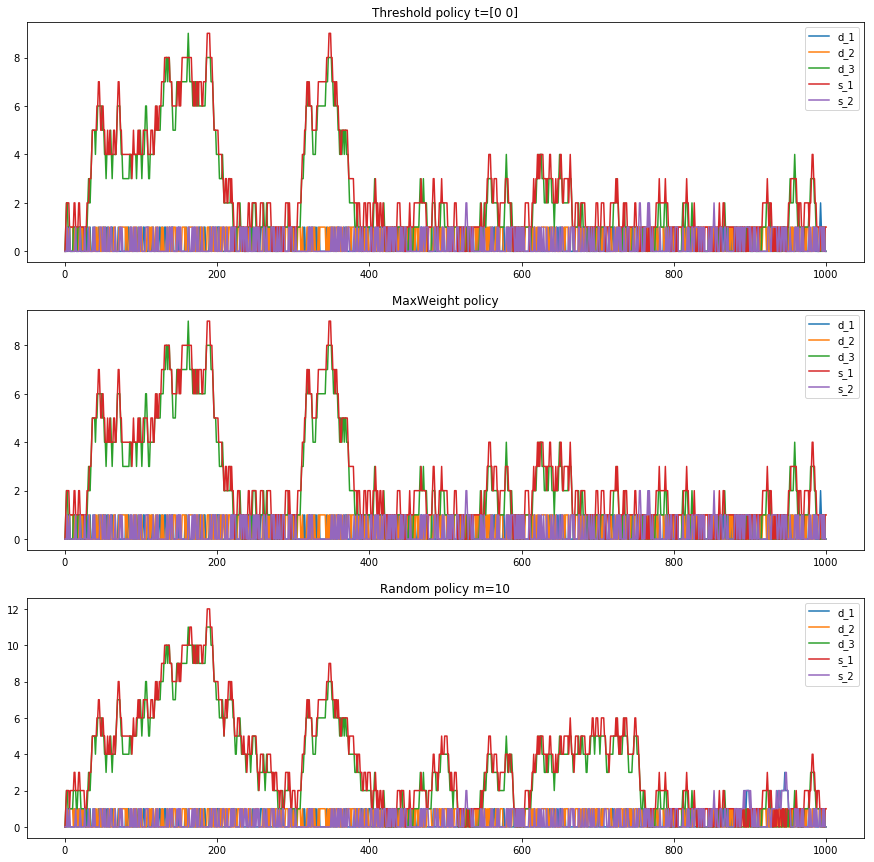

In [5]:
t = test_model.run(1000,P,plot=True)

In [6]:
t

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  1.],
        [ 0.,  1.,  2., ...,  1.,  0.,  0.],
        [ 0.,  1.,  2., ...,  0.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  1.],
        [ 0.,  1.,  2., ...,  1.,  0.,  0.],
        [ 0.,  1.,  2., ...,  0.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  1.],
        [ 0.,  1.,  2., ...,  1.,  0.,  0.],
        [ 0.,  1.,  2., ...,  0.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.]]])

In [7]:
N = 10000
c = test_model.average_cost(N,P,plot=True)

KeyboardInterrupt: 

In [4]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
P = [Threshold_policy(np.array([0,0])),MaxWeight_policy(costs),Random_policy(10)]
x0 = State.zeros(W)
test_model = Model(W,alpha,beta,costs,x0)

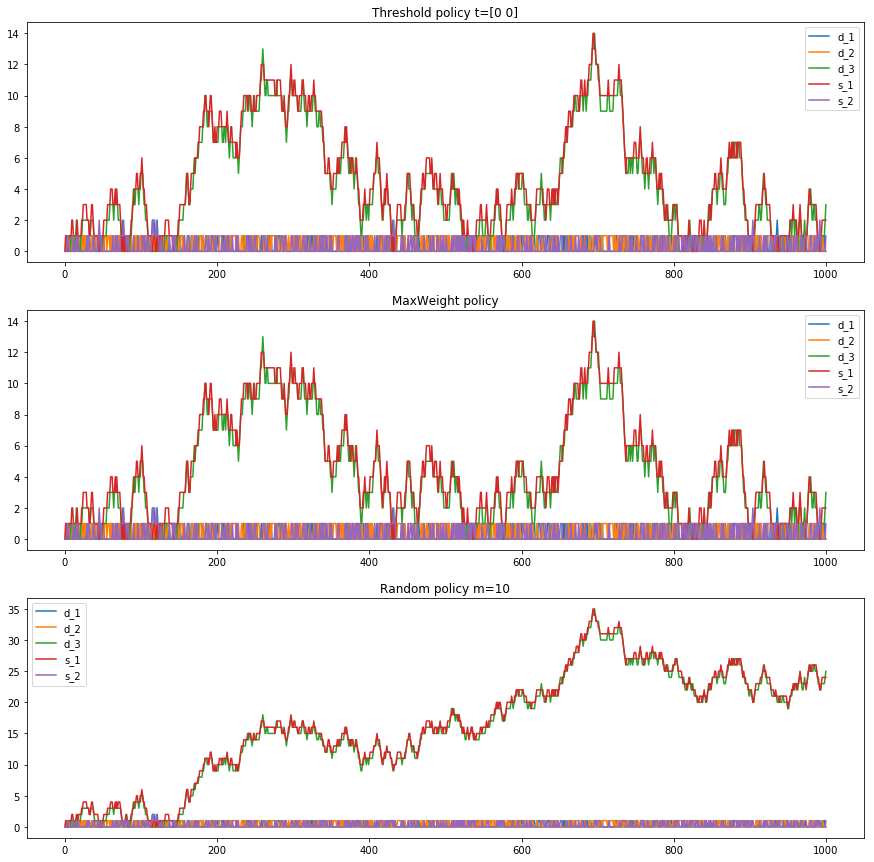

In [5]:
t = test_model.run(1000,P,plot=True)

In [123]:
t

array([[[  0.,   0.,   0., ...,   1.,   0.,   0.],
        [  0.,   1.,   1., ...,   0.,   1.,   1.],
        [  0.,   0.,   0., ...,   9.,   9.,   9.],
        [  0.,   0.,   1., ...,  10.,  10.,  10.],
        [  0.,   1.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   1.,   0.,   0.],
        [  0.,   1.,   1., ...,   0.,   1.,   1.],
        [  0.,   0.,   0., ...,   9.,   9.,   9.],
        [  0.,   0.,   1., ...,  10.,  10.,  10.],
        [  0.,   1.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   1.,   0.,   0.],
        [  0.,   1.,   1., ...,   0.,   1.,   1.],
        [  0.,   0.,   0., ...,  31.,  31.,  31.],
        [  0.,   0.,   1., ...,  32.,  32.,  32.],
        [  0.,   1.,   0., ...,   0.,   0.,   0.]]])

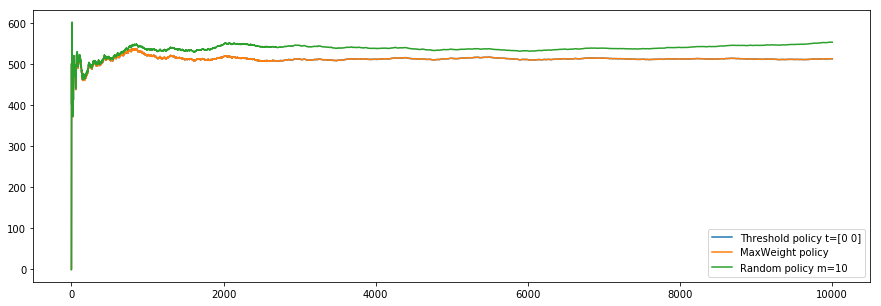

In [124]:
N = 10000
c = test_model.average_cost(N,P,plot=True)

In [6]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
P = [Stolyar_policy(x0,rewards=np.array([0,0,0,0]),beta=0.5),
     Stolyar_policy(x0,rewards=np.array([0,0,0,0]),beta=0.5,costs=costs),
     Stolyar_policy(x0,rewards=np.array([1.,1.,1.,1.]),beta=0.5,costs=costs)]
x0 = State.zeros(W)
test_model = Model(W,alpha,beta,costs,x0)

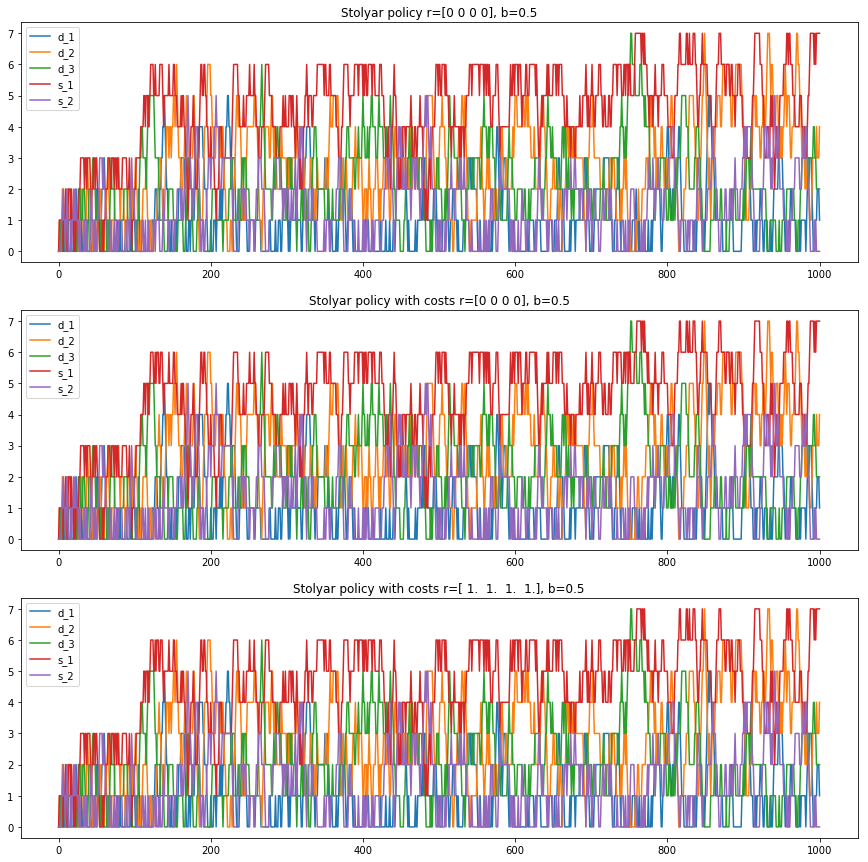

In [7]:
t = test_model.run(1000,P,plot=True)

In [8]:
t

array([[[ 0.,  0.,  1., ...,  2.,  2.,  1.],
        [ 0.,  1.,  0., ...,  3.,  3.,  4.],
        [ 0.,  0.,  0., ...,  2.,  2.,  2.],
        [ 0.,  1.,  1., ...,  7.,  7.,  7.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  1., ...,  2.,  2.,  1.],
        [ 0.,  1.,  0., ...,  3.,  3.,  4.],
        [ 0.,  0.,  0., ...,  2.,  2.,  2.],
        [ 0.,  1.,  1., ...,  7.,  7.,  7.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  1., ...,  2.,  2.,  1.],
        [ 0.,  1.,  0., ...,  3.,  3.,  4.],
        [ 0.,  0.,  0., ...,  2.,  2.,  2.],
        [ 0.,  1.,  1., ...,  7.,  7.,  7.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])

In [11]:
(t[1,:,:]==t[2,:,:]).all()

True

In [60]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
P = Threshold_policy(np.array([0,0]))
x0 = State.zeros(W)
test_model = Model(W,alpha,beta,costs,x0)

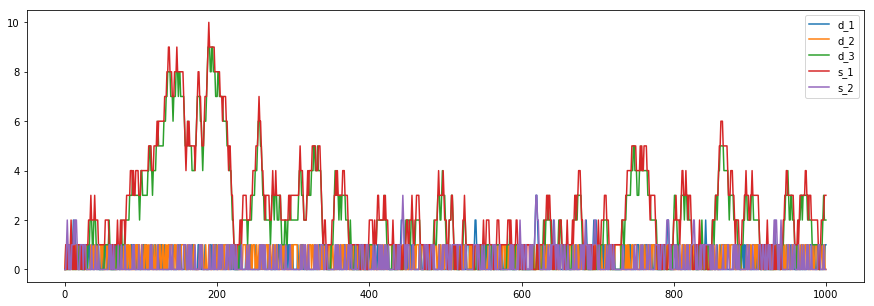

In [61]:
t = test_model.run(1000,P,plot=True)

In [62]:
t

array([[ 0.,  0.,  1., ...,  0.,  1.,  1.],
       [ 0.,  1.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  2.,  2.,  2.],
       [ 0.,  1.,  0., ...,  3.,  3.,  3.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.]])

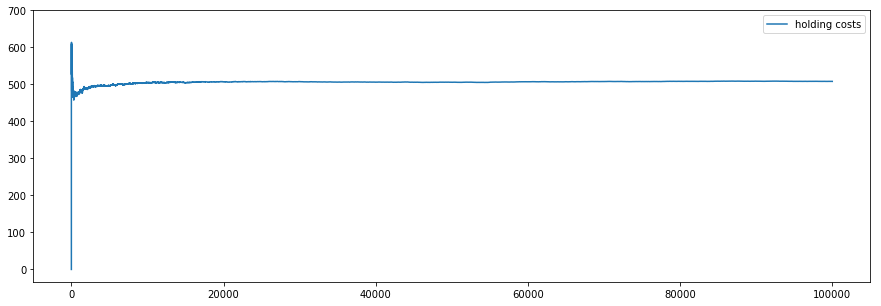

In [63]:
N = 100000
c = test_model.average_cost(N,P,plot=True)

In [64]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
x0 = State.zeros(W)
P = Stolyar_policy(x0,rewards=np.array([0,0,0,0]),beta=0.5)
test_model = Model(W,alpha,beta,costs,x0)

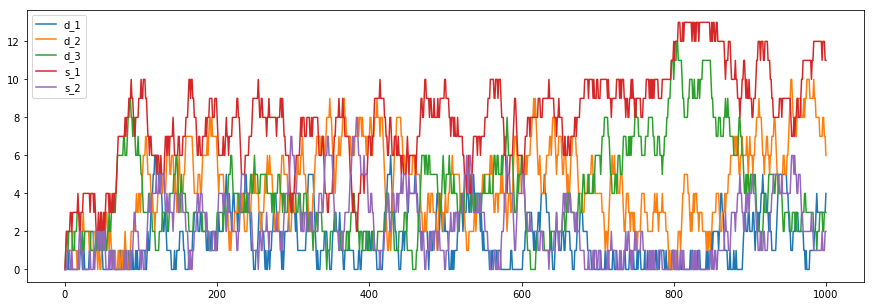

In [65]:
t = test_model.run(1000,P,plot=True)

In [66]:
t

array([[  0.,   0.,   0., ...,   3.,   3.,   4.],
       [  0.,   0.,   0., ...,   7.,   7.,   6.],
       [  0.,   1.,   2., ...,   3.,   3.,   3.],
       [  0.,   1.,   2., ...,  12.,  11.,  11.],
       [  0.,   0.,   0., ...,   1.,   2.,   2.]])

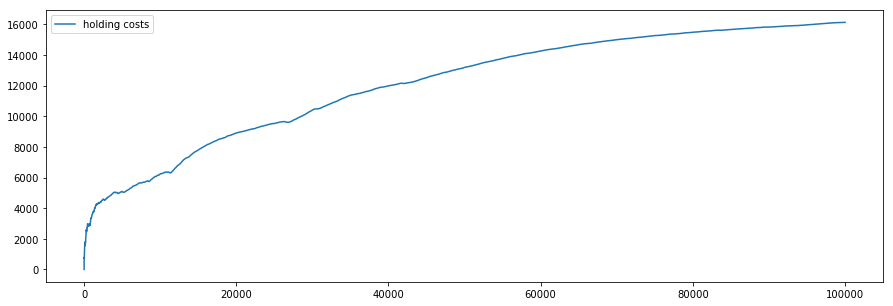

In [67]:
N = 100000
c = test_model.average_cost(N,P,plot=True)

In [68]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
x0 = State.zeros(W)
P = Stolyar_policy(x0,rewards=np.array([0,0,0,0]),beta=0.5,costs=costs)
test_model = Model(W,alpha,beta,costs,x0)

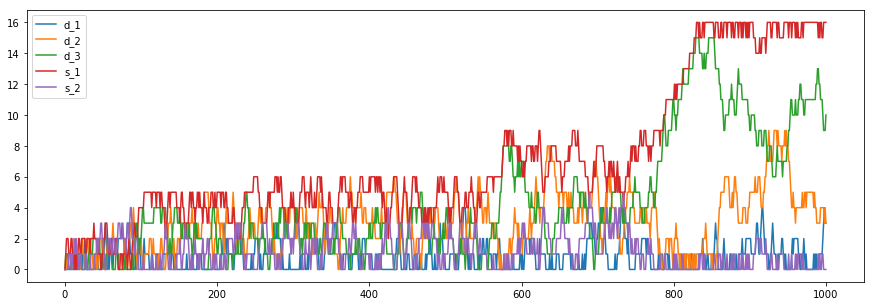

In [69]:
t = test_model.run(1000,P,plot=True)

In [70]:
t

array([[  0.,   0.,   0., ...,   4.,   3.,   3.],
       [  0.,   0.,   1., ...,   3.,   4.,   3.],
       [  0.,   1.,   1., ...,   9.,   9.,  10.],
       [  0.,   1.,   2., ...,  16.,  16.,  16.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

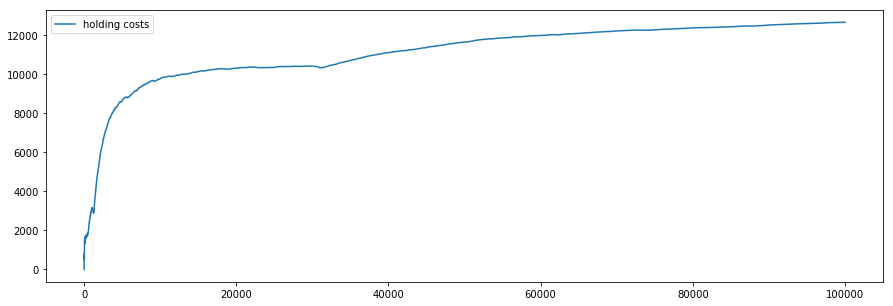

In [71]:
N = 100000
c = test_model.average_cost(N,P,plot=True)

In [72]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
x0 = State.zeros(W)
P = Stolyar_policy(x0,rewards=np.array([1.,1.,1.,1.]),beta=0.5,costs=costs)
test_model = Model(W,alpha,beta,costs,x0)

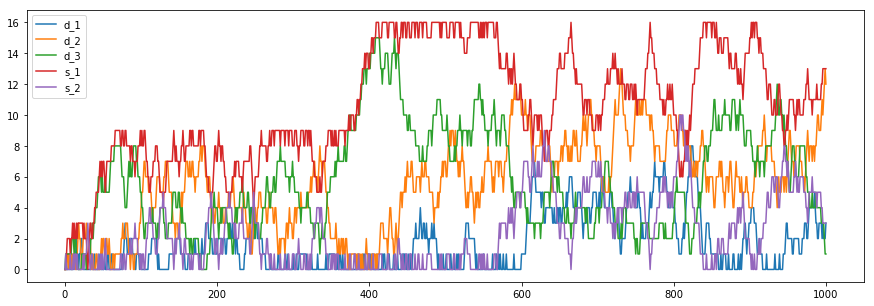

In [73]:
t = test_model.run(1000,P,plot=True)

In [74]:
t

array([[  0.,   0.,   0., ...,   2.,   2.,   3.],
       [  0.,   0.,   0., ...,  12.,  13.,  12.],
       [  0.,   1.,   1., ...,   2.,   1.,   1.],
       [  0.,   0.,   1., ...,  13.,  13.,  13.],
       [  0.,   1.,   0., ...,   3.,   3.,   3.]])

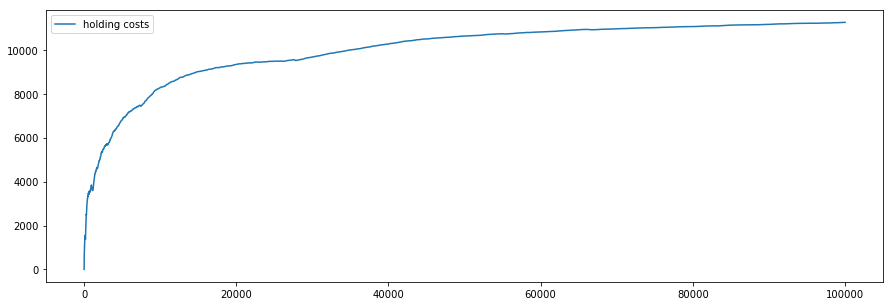

In [75]:
N = 100000
c = test_model.average_cost(N,P,plot=True)

In [39]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
P = MaxWeight_policy(costs)
x0 = State.zeros(W)
test_model = Model(W,alpha,beta,costs,x0)

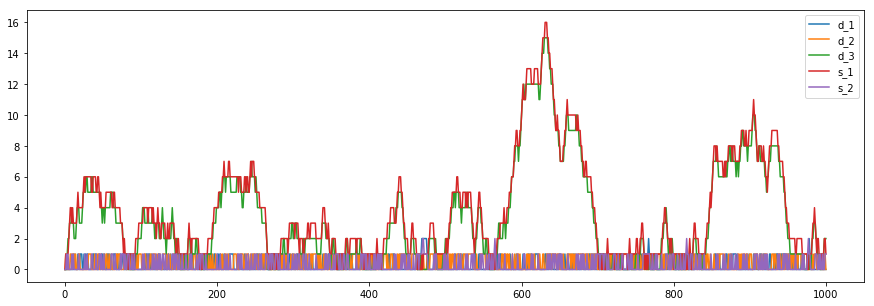

In [40]:
t = test_model.run(1000,P,plot=True)

In [41]:
t

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  2.,  2.,  2.],
       [ 0.,  1.,  0., ...,  2.,  2.,  1.],
       [ 0.,  0.,  1., ...,  0.,  1.,  1.]])

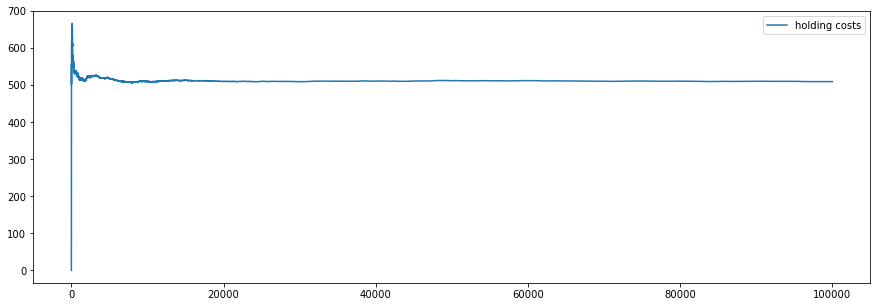

In [42]:
N = 100000
c = test_model.average_cost(N,P,plot=True)

In [43]:
W = MatchingGraph([(1,1),(2,1),(2,2),(3,2)],3,2)
alpha = np.array([0.25,0.5,0.25])
beta = np.array([0.7,0.3])
costs = NodesData(np.array([1., 1000., 1., 1., 1.]),W)
P = Random_policy(10)
x0 = State.zeros(W)
test_model = Model(W,alpha,beta,costs,x0)

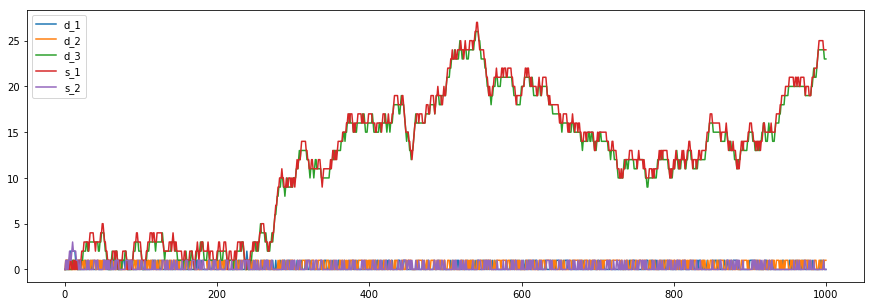

In [44]:
t = test_model.run(1000,P,plot=True)

In [45]:
t

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   1.,   1., ...,   1.,   1.,   1.],
       [  0.,   0.,   0., ...,  23.,  23.,  23.],
       [  0.,   0.,   1., ...,  24.,  24.,  24.],
       [  0.,   1.,   0., ...,   0.,   0.,   0.]])

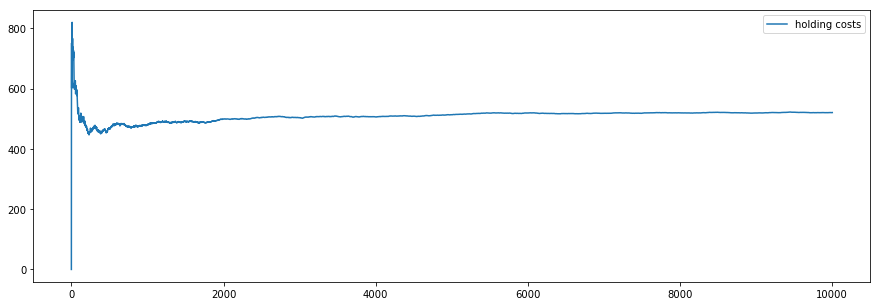

In [46]:
N = 10000
c = test_model.average_cost(N,P,plot=True)